#AIRBNB CLASSIFIER

Import statements:

In [ ]:
#import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import imblearn
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier 
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import train_test_split 
from sklearn import metrics
import statsmodels.api as sm
from statsmodels.formula.api import logit, glm, ols
from sklearn.tree import export_graphviz
from IPython.display import Image 
from sklearn import tree
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from pprint import pprint 
import sys
import pydotplus
import geopy
import numpy as np
import warnings                                               
warnings.filterwarnings("ignore")
from sklearn.ensemble import RandomForestRegressor
import json
from google.colab import files
import random
import nltk
# downlaod some resouces
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('vader_lexicon')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.neighbors import KNeighborsClassifier


# load the sentiment function
sia = SentimentIntensityAnalyzer()
# load the stemmer function 
porter = nltk.PorterStemmer()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!




```
# This is formatted as code
```

# Some basic check at our dataset:

In [ ]:
#load in airbnb dataset
df = pd.read_csv('listings.csv') 
df.head()

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,2384,https://www.airbnb.com/rooms/2384,20211018161857,2021-10-19,Hyde Park - Walk to University of Chicago,"If you are fully vaccinated, and able to climb...",The apartment is less than one block from beau...,https://a0.muscache.com/pictures/acf6b3c0-47f2...,2613,https://www.airbnb.com/users/show/2613,Rebecca,2008-08-29,"Chicago, Illinois, United States",My 2 bdrm apartment is a 2nd floor walk-up in ...,within an hour,100%,83%,t,https://a0.muscache.com/im/pictures/user/8bb47...,https://a0.muscache.com/im/pictures/user/8bb47...,Hyde Park,1.0,1.0,"['email', 'phone', 'reviews', 'manual_offline'...",t,t,"Chicago, Illinois, United States",Hyde Park,NaN,41.78790,-87.58780,Private room in condominium (condo),Private room,1,NaN,1 shared bath,1.0,1.0,"[""Hot water"", ""Gas stove"", ""Essentials"", ""Room...",$81.00,3,30,3,3,1125,1125,3.0,1125.0,NaN,t,19,40,55,329,2021-10-19,190,10,2,2015-04-30,2021-09-24,4.99,4.98,4.99,4.98,4.98,4.95,4.94,R17000015609,f,1,0,1,0,2.41
1,7126,https://www.airbnb.com/rooms/7126,20211018161857,2021-10-18,Tiny Studio Apartment 94 Walk Score,A very small studio in a wonderful neighborhoo...,"Ukrainian Village was just named ""Hottest Neig...",https://a0.muscache.com/pictures/51073/16c81c7...,17928,https://www.airbnb.com/users/show/17928,Sarah,2009-05-19,"Chicago, Illinois, United States",We live in Chicago. We love to travel and see ...,NaN,NaN,NaN,t,https://a0.muscache.com/im/users/17928/profile...,https://a0.muscache.com/im/users/17928/profile...,Ukrainian Village,2.0,2.0,"['email', 'phone', 'reviews', 'jumio', 'offlin...",t,t,"Chicago, Illinois, United States",West Town,NaN,41.90166,-87.68021,Entire rental unit,Entire home/apt,2,NaN,1 bath,1.0,1.0,"[""Hot water"", ""Stove"", ""Essentials"", ""Room-dar...",$65.00,2,60,2,2,1125,1125,2.0,1125.0,NaN,t,5,22,48,230,2021-10-18,414,29,6,2011-08-10,2021-10-06,4.66,4.83,4.53,4.89,4.86,4.87,4.72,R18000034991,f,1,1,0,0,3.34
2,10945,https://www.airbnb.com/rooms/10945,20211018161857,2021-10-18,The Biddle House (#1),Beautiful first floor apartment in Historic Ol...,NaN,https://a0.muscache.com/pictures/58d1a420-a24b...,33004,https://www.airbnb.com/users/show/33004,At Home Inn,2009-08-21,"Chicago, Illinois, United States","Hi, we're Bob and Liz Biddle, long time Chicag...",within an hour,94%,92%,t,https://a0.muscache.com/im/pictures/user/e23d4...,https://a0.muscache.com/im/pictures/user/e23d4...,Old Town,7.0,7.0,"['email', 'phone', 'reviews', 'jumio', 'govern...",t,t,NaN,Lincoln Park,NaN,41.91196,-87.63981,Entire rental unit,Entire home/apt,4,NaN,1 bath,2.0,2.0,"[""Hot water"", ""Stove"", ""Essentials"", ""Kitchen""...",$125.00,4,180,4,4,180,180,4.0,180.0,NaN,t,12,33,54,144,2021-

In [ ]:
#see the distribution of our data
df.describe()

,id,scrape_id,host_id,host_listings_count,host_total_listings_count,neighbourhood_group_cleansed,latitude,longitude,accommodates,bathrooms,bedrooms,beds,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
count,6.528000e+03,6.528000e+03,6.528000e+03,6525.000000,6525.000000,0.0,6528.000000,6528.000000,6528.000000,0.0,5953.000000,6469.000000,6528.000000,6528.000000,6528.000000,6528.000000,6.528000e+03,6.528000e+03,6528.000000,6.528000e+03,0.0,6528.000000,6528.000000,6528.000000,6528.000000,6528.000000,6528.000000,6528.000000,5510.000000,5478.000000,5478.000000,5477.000000,5476.000000,5477.000000,5477.000000,6528.000000,6528.000000,6528.000000,6528.000000,5510.000000
mean,3.305271e+07,2.021102e+13,1.217399e+08,109.245977,109.245977,NaN,41.898251,-87.663115,4.092371,NaN,1.768016,2.115010,9.211397,694.827512,10.242647,44.216452,5.593242e+06,7.567086e+06,42.599081,7.562612e+06,NaN,12.023591,28.333333,46.912990,178.385110,46.377145,11.925858,1.491881,4.705561,4.795285,4.727786,4.852027,4.848402,4.785941,4.694691,22.345895,20.532016,1.533241,0.151654,3.521632
std,1.494224e+07,9.297587e-01,1.200565e+08,446.715318,446.715318,NaN,0.058499,0.042220,2.851444,NaN,1.078304,1.722313,22.728897,504.515065,33.852630,156.131612,1.094539e+08,1.272537e+08,151.275062,1.271786e+08,NaN,11.293922,22.799640,33.850881,137.490354,75.133071,22.877154,2.437626,0.533349,0.365877,0.399645,0.319597,0.349536,0.342330,0.397080,66.699864,67.029716,3.737208,1.413448,7.855918
min,2.384000e+03,2.021102e+13,2.153000e+03,0.000000,0.000000,NaN,41.650640,-87.864150,0.000000,NaN,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000e+00,1.000000e+00,1.000000,1.000000e+00,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.010000
25%,2.140874e+07,2.021102e+13,2.191582e+07,1.000000,1.000000,NaN,41.872585,-87.686815,2.000000,NaN,1.000000,1.000000,1.000000,60.000000,2.000000,2.000000,3.650000e+02,1.124000e+03,2.000000,9.736000e+02,NaN,0.000000,0.000000,7.000000,44.000000,2.000000,0.000000,0.000000,4.660000,4.750000,4.640000,4.840000,4.840000,4.730000,4.620000,1.000000,1.000000,0.000000,0.000000,0.530000
50%,3.652392e+07,2.021102e+13,8.490272e+07,2.000000,2.000000,NaN,41.899715,-87.659450,4.000000,NaN,1.000000,2.000000,2.000000,1125.000000,2.000000,3.000000,1.125000e+03,1.125000e+03,2.000000,1.125000e+03,NaN,11.000000,31.000000,54.000000,166.000000,16.000000,4.000000,0.000000,4.840000,4.900000,4.850000,4.940000,4.960000,4.890000,4.790000,2.000000,1.000000,0.000000,0.000000,1.720000
75%,4.641521e+07,2.021102e+13,1.915230e+08,10.000000,10.000000,NaN,41.938783,-87.632417,5.000000,NaN,2.000000,3.000000,4.000000,1125.000000,4.000000,6.000000,1.125000e+03,1.125000e+03,5.000000,1.125000e+03,NaN,22.250000,49.000000,78.000000,327.000000,57.000000,18.000000,3.000000,4.960000,5.000000,4.980000,5.000000,5.000000,5.000000,4.910000,9.000000,5.000000,1.000000,0.000000,3.760000
max,5.282783e+07,2.021102e+13,4.273566e+08,5897.000000,5897.000000,NaN,42.022200,-87.535880,16.000000,NaN,12.000000,25.000000,500.000000,1125.000000,730.000000,730.000000,2.147484e+09,2.147484e+09,730.000000,2.147484e+09,NaN,30.000000,60.000000,90.000000,365.000000,1390.000000,982.000000,65.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,313.000000,313.000000,26.000000,17.000000,2

In [ ]:
#see df info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6528 entries, 0 to 6527
Data columns (total 74 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            6528 non-null   int64  
 1   listing_url                                   6528 non-null   object 
 2   scrape_id                                     6528 non-null   int64  
 3   last_scraped                                  6528 non-null   object 
 4   name                                          6528 non-null   object 
 5   description                                   6512 non-null   object 
 6   neighborhood_overview                         4755 non-null   object 
 7   picture_url                                   6528 non-null   object 
 8   host_id                                       6528 non-null   int64  
 9   host_url                                      6528 non-null   o

Lets create our classification variable. We will be using price as our classification variable. The average value is 126 (after removing outliers) so we will create two classifcation variables using price Economy (price below 126) and Luxury (price above 126):

In [ ]:
#Since price does not have any null values we can immediately create our classification variable:
df['PriceClass'] = 'na'

df.price= df['price'].str.replace("$", '')
df.price= df['price'].str.replace(",", '')
df.price = df['price'].astype(float)

for index, value in enumerate(df.price): 
  if value <= 126 :
    df['PriceClass'][index] = 'Economy'
  else:
    df['PriceClass'][index] = 'Luxury'

y = df.loc[:,['price', 'PriceClass']].values
print(y)

[[81.0 'Economy']
 [65.0 'Economy']
 [125.0 'Economy']
 ...
 [105.0 'Economy']
 [229.0 'Luxury']
 [175.0 'Luxury']]


Lets take a look at the distribution of our class variable: 

In [ ]:
print(df.PriceClass.value_counts())
temp = df.groupby('PriceClass').nunique#.count()#.reset_index()[['PriceClass','id']].rename(columns={"id":"count_of_each_class"})
#plt.bar(temp['PriceClass'], temp['count_of_each_class'])
#plt.xlabel('Class'),plt.ylabel('Count'),plt.title('Distribution of Each Class')

Economy    3557
Luxury     2971
Name: PriceClass, dtype: int64


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6528 entries, 0 to 6527
Data columns (total 75 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            6528 non-null   int64  
 1   listing_url                                   6528 non-null   object 
 2   scrape_id                                     6528 non-null   int64  
 3   last_scraped                                  6528 non-null   object 
 4   name                                          6528 non-null   object 
 5   description                                   6512 non-null   object 
 6   neighborhood_overview                         4755 non-null   object 
 7   picture_url                                   6528 non-null   object 
 8   host_id                                       6528 non-null   int64  
 9   host_url                                      6528 non-null   o

In [ ]:
df.host_id.nunique()

3400

Looks like our distribution is pretty good, we have a good distribution of our class variable.

#Benchmarking (without Preprocessing): Decision Tree Random Forest and Logistic Regression Classifier

For our intial benchmarking, we are replacing na values with average (instead of removing the rows because if we remove rows there is huge information loss) and we are convertinig categorical variables into dummy variables. 

In [ ]:
df1 = df.copy()
#df1.dropna(inplace = True)
#df1.info()
#print(y)
#print(df.head())

#feature pre-processing
columns = ['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'description', 'neighborhood_overview', 'picture_url', 'host_id', 'host_url', 'host_name', 'host_since', 'host_location', 'host_about', 'host_response_time', 'host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood', 'host_listings_count', 'host_total_listings_count', 'host_verifications', 'host_has_profile_pic', 'host_identity_verified', 'neighbourhood', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude', 'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms', 'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price', 'minimum_nights', 'maximum_nights', 'minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights', 'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'calendar_updated', 'has_availability', 'availability_30', 'availability_60', 'availability_90', 'availability_365', 'calendar_last_scraped', 'number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d', 'first_review', 'last_review', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'license', 'instant_bookable', 'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms', 'reviews_per_month', 'PriceClass']
features = ['host_response_rate', 'host_acceptance_rate', 'host_is_superhost','host_has_profile_pic', 'host_identity_verified', 'latitude', ' longitude', 'room_type', 'accommodates', 'bathrooms_text', 'bedrooms', 'beds', 'minimum_nights', 'maximum_nights', 'number_of_reviews', 'review_scores_rating','review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'reviews_per_month']

#replace t and f with 1 and 0 
df1.replace(to_replace={'host_is_superhost' : {'t': 1, 'f' : 0}, 'host_has_profile_pic' : {'t' : 1, 'f' : 0},'host_identity_verified' : {'t' : 1, 'f' : 0}, 'PriceClass':{'Economy': 0, 'Luxury': 1} }, inplace = True)


#host response rate: na 1466
df1.host_response_rate= df1['host_response_rate'].str.replace("%", '')
df1.host_response_rate = df1['host_response_rate'].astype(float)
df1['host_response_rate'].fillna(df1.host_response_rate.mean(), inplace = True)


#host_acceptance_rate: na 1300
df1.host_acceptance_rate= df1['host_acceptance_rate'].str.replace("%", '')
df1.host_acceptance_rate = df1['host_acceptance_rate'].astype(float)
df1['host_acceptance_rate'].fillna(df1.host_acceptance_rate.mean(), inplace = True)
df1.host_acceptance_rate.isna().sum()
#print(df.host_acceptance_rate.isna().sum())

#host_is_superhost: na 3 (checked url and they were all superhost)
df1['host_is_superhost'].fillna(1, inplace = True)
#df1.host_is_superhost.isna().sum()

#host_has_profile_pic: na 3 (checked url and they all had profile)
df1['host_has_profile_pic'].fillna(1, inplace = True)
#df1.host_has_profile_pic.isna().sum()

# host_identity_verified: na 3 (checked url and they all were verified)
df1['host_identity_verified'].fillna(1, inplace = True)
#df1.host_identity_verified.isna().sum()

#latitude: na 0
#df1.latitude.isna().sum()

#longitude: na 0
#df1.longitude.isna().sum()

#room_type: na 0 (we need to use dummy variables to represent this in our data)
#df1.room_type.isna().sum()
room_type = pd.get_dummies(df1['room_type'],drop_first=True)
#print(room_type)

#accommodates: na 0 
#df1.accommodates.isna().sum()

#bathrooms_text (we need to divide this into number of bath and type of bath)
split = df1['bathrooms_text'].str.split(' ').str[0]
for j, i in enumerate(split): 
  if not str(i).isnumeric() and '.' not in str(i):
    if pd.isnull(i):
      split[j] = 1
    else:
      split[j] = 0.5
df1['num_bathrooms'] = split
split = df1['bathrooms_text'].str.split(' ').str[1]
for j,i in enumerate(split):
  if not (i == 'shared' or i == 'private'):
    split[j] = 'bath'
df1['bathrooms_type'] = split
bathrooms_type = pd.get_dummies(df1['bathrooms_type'],drop_first=True)

#bedrooms: na 575
df1['bedrooms'].fillna(df1.bedrooms.mean(), inplace = True)
#df1.bedrooms.isna().sum()

#beds: na 59
df1.beds.fillna(df1.beds.mean(), inplace = True)
#df.beds.isna().sum()

#minimum_nights: na 0
#print(df.minimum_nights.isna().sum())

#maximum_nights: na 0 
#print(df.maximum_nights.isna().sum())

#number_of_reviews: na 
#print(df.number_of_reviews.isna().sum())

#review_scores_rating: na 1050
df1.review_scores_rating.fillna(df1.review_scores_rating.mean(), inplace = True)
#print(df.review_scores_rating.isna().sum())

#review_scores_accuracy: na 1050
df1.review_scores_accuracy.fillna(df1.review_scores_accuracy.mean(), inplace = True)
#print(df.review_scores_accuracy.isna().sum())

#review_scores_cleanliness: na 1050
df1.review_scores_cleanliness.fillna(df1.review_scores_cleanliness.mean(), inplace = True)
#print(df.review_scores_accuracy.isna().sum())

#review_scores_checkin: na 1051
df1.review_scores_checkin.fillna(df1.review_scores_checkin.mean(), inplace = True)
#print(df.review_scores_checkin.isna().sum())

#review_scores_communication: na 1052
df1.review_scores_communication.fillna(df1.review_scores_communication.mean(), inplace = True)
#print(df.review_scores_communication.isna().sum())

#review_scores_location: na 1051
df1.review_scores_location.fillna(df1.review_scores_location.mean(), inplace = True)
#print(df.review_scores_location.isna().sum())

#review_scores_value: na 1051
df1.review_scores_value.fillna(df1.review_scores_value.mean(), inplace = True)
#print(df1.review_scores_value.isna().sum())

#reviews_per_month: na 1018
df1.reviews_per_month.fillna(df1.reviews_per_month.mean(), inplace = True)
#print(df.reviews_per_month.isna().sum())


#reminder concat room_type and drop room_type col, bathrooms_text
df1.drop(['room_type', 'bathrooms_text'],axis=1,inplace=True)
df1 = pd.concat([df1,room_type, bathrooms_type],axis=1)

df1.rename(columns = {"Hotel room":"Hotel_room", "Private room": "Private_room", "Shared room": "Shared_room"}, inplace = True)

new_features = ['host_response_rate', 'host_acceptance_rate', 'host_is_superhost','host_has_profile_pic', 'host_identity_verified', 'latitude', 'longitude', 'Hotel_room', 'Private_room', 'Shared_room', 'private', 'shared', 'num_bathrooms', 'accommodates', 'bedrooms', 'beds', 'minimum_nights', 'maximum_nights', 'number_of_reviews', 'review_scores_rating','review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'reviews_per_month']
classification = ['PriceClass']

df1.num_bathrooms = df1['num_bathrooms'].astype(float)
df1.info()
print(df1['PriceClass'])


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6528 entries, 0 to 6527
Data columns (total 80 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            6528 non-null   int64  
 1   listing_url                                   6528 non-null   object 
 2   scrape_id                                     6528 non-null   int64  
 3   last_scraped                                  6528 non-null   object 
 4   name                                          6528 non-null   object 
 5   description                                   6512 non-null   object 
 6   neighborhood_overview                         4755 non-null   object 
 7   picture_url                                   6528 non-null   object 
 8   host_id                                       6528 non-null   int64  
 9   host_url                                      6528 non-null   o

In [ ]:
logit_model = logit('PriceClass ~ host_response_rate + host_acceptance_rate + host_is_superhost + host_has_profile_pic + host_identity_verified + latitude + longitude + Hotel_room + Private_room + Shared_room + private + shared + num_bathrooms + accommodates + bedrooms + beds + minimum_nights + maximum_nights + number_of_reviews + review_scores_rating + review_scores_accuracy + review_scores_cleanliness + review_scores_checkin + review_scores_communication + review_scores_location + review_scores_value + reviews_per_month', df1).fit()
print(logit_model.summary())



Optimization terminated successfully.
         Current function value: 0.460999
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:             PriceClass   No. Observations:                 6528
Model:                          Logit   Df Residuals:                     6500
Method:                           MLE   Df Model:                           27
Date:                Wed, 24 Nov 2021   Pseudo R-squ.:                  0.3310
Time:                        19:37:22   Log-Likelihood:                -3009.4
converged:                       True   LL-Null:                       -4498.5
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                    1170.1033     79.902     14.644      0.000   

In [ ]:
X = df1[new_features]
y = df1[classification]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
#logistic regression
model = LogisticRegression(solver='lbfgs', max_iter=1000)
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print(classification_report(y_test,y_pred))

[[903 203]
 [273 580]]
Accuracy: 0.7570188871873405
              precision    recall  f1-score   support

           0       0.77      0.82      0.79      1106
           1       0.74      0.68      0.71       853

    accuracy                           0.76      1959
   macro avg       0.75      0.75      0.75      1959
weighted avg       0.76      0.76      0.76      1959



In [ ]:
#decision trees
clf = DecisionTreeClassifier(criterion="entropy", max_depth=6)
clf = clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.7820316488004083
[[857 249]
 [178 675]]
              precision    recall  f1-score   support

           0       0.83      0.77      0.80      1106
           1       0.73      0.79      0.76       853

    accuracy                           0.78      1959
   macro avg       0.78      0.78      0.78      1959
weighted avg       0.79      0.78      0.78      1959



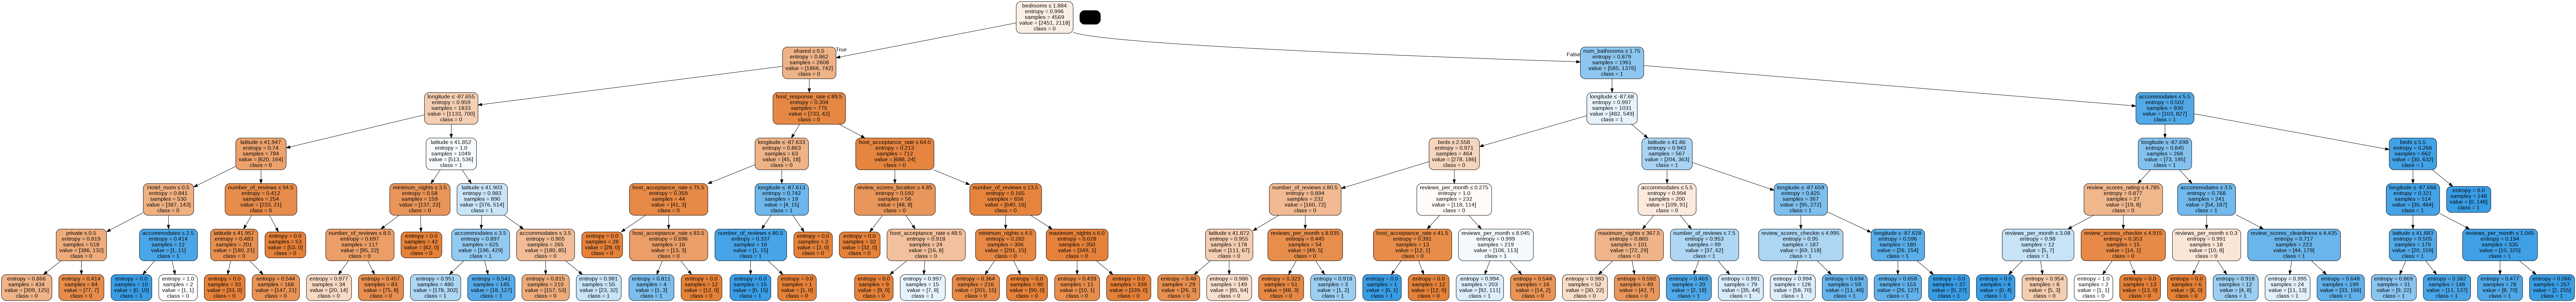

In [ ]:
#visulization
from six import StringIO  
dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = new_features,class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('airbnb.png')
Image(graph.create_png())


In [ ]:
#random forest 
clf = RandomForestClassifier(max_depth=6, random_state=0)
clf = clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.7937723328228689
[[909 197]
 [207 646]]
              precision    recall  f1-score   support

           0       0.81      0.82      0.82      1106
           1       0.77      0.76      0.76       853

    accuracy                           0.79      1959
   macro avg       0.79      0.79      0.79      1959
weighted avg       0.79      0.79      0.79      1959



In [ ]:
knn = KNeighborsClassifier(n_neighbors = 4).fit(X_train, y_train)
# accuracy on X_test
accuracy = knn.score(X_test, y_test)
print(accuracy)
# creating a confusion matrix
knn_predictions = knn.predict(X_test)
cm = confusion_matrix(y_test, knn_predictions)
print(cm)

0.6789178152118428
[[907 199]
 [430 423]]


#Benchmarking (with Preprocessing): Decision Tree Random Forset and Logistic Regression Classifier

In [ ]:
df2 = df.copy()

#feature pre-processing
columns = ['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'description', 'neighborhood_overview', 'picture_url', 'host_id', 'host_url', 'host_name', 'host_since', 'host_location', 'host_about', 'host_response_time', 'host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood', 'host_listings_count', 'host_total_listings_count', 'host_verifications', 'host_has_profile_pic', 'host_identity_verified', 'neighbourhood', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude', 'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms', 'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price', 'minimum_nights', 'maximum_nights', 'minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights', 'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'calendar_updated', 'has_availability', 'availability_30', 'availability_60', 'availability_90', 'availability_365', 'calendar_last_scraped', 'number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d', 'first_review', 'last_review', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'license', 'instant_bookable', 'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms', 'reviews_per_month', 'PriceClass']
features = ['host_response_rate', 'host_acceptance_rate', 'host_is_superhost','host_has_profile_pic', 'host_identity_verified', 'latitude', ' longitude', 'room_type', 'accommodates', 'bathrooms_text', 'bedrooms', 'beds', 'minimum_nights', 'maximum_nights', 'number_of_reviews', 'review_scores_rating','review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'reviews_per_month']
#replace t and f with 1 and 0 
df2.replace(to_replace={'host_is_superhost':{'t':1,'f':0},'host_has_profile_pic':{'t':1,'f':0},'host_identity_verified':{'t':1,'f':0}},
           inplace = True)

Here we add reviews data of Chicago from Airbnb and do sentiment
analysis on the comment of each hotel.

In [ ]:
review = pd.read_csv('reviews.csv')

# the key used to merge review and df data is listing_id in review data and id in df data
# First we put all of comments of each hotel into one row
comment = {} 
for index, value in enumerate(review['listing_id']):
  if value not in comment.keys():
    comment[value] = str(review.loc[index,'comments'])
  else:
    comment[value] = comment[value] + ' ' + str(review.loc[index,'comments'])

# Change the type into DataFrame for the convenience of later sentiment analysis
keys = []
text = []
for key,value in comment.items():
  keys.append(key)
  text.append(value)
review_text = pd.DataFrame({'key':keys,'text':text})

# Removing everything except alphabets`
review_text['text'] = review_text['text'].str.replace("[^a-zA-Z#]", " ")
# Make all text lowercase
review_text['text'] = review_text['text'].apply(lambda x: x.lower())
# Split the sentence into words like ("i like you") into ["i" "like" "you"]
review_text['text'] = review_text['text'].apply(lambda x: x.split())

# Remove stopwords from text
review_text['clean_text'] = 'na'
stopword = list(stopwords.words('english'))
for index,value in enumerate(review_text['text']): 
  for L in value:
    if L in set(stopword):
      value.remove(L)
  review_text['clean_text'][index] = value 
# Calculate overall sentimental score of each hotel 
scores = {}
for index,value in enumerate(review_text['clean_text']):
  value = " ".join(value)
  score = sia.polarity_scores(value)
  if 'pos' not in scores.keys():
    scores['pos'] = [score['pos']]
  else:
    scores['pos'].append(score['pos'])
  if 'neg' not in scores.keys():
    scores['neg'] = [score['neg']]
  else:
    scores['neg'].append(score['neg'])
  if 'neu' not in scores.keys():
    scores['neu'] = [score['neu']]
  else:
    scores['neu'].append(score['neu'])
  if 'compound' not in scores.keys():
    scores['compound'] = [score['compound']]
  else:
    scores['compound'].append(score['compound'])
# Merge sentimental score data and df data into one DataFrame
scores_dataframe = pd.DataFrame(scores)
review_text_score = pd.concat([review_text,scores_dataframe],axis=1)
df2 =df2.merge(review_text_score,how='left',left_on='id', right_on='key')

In [ ]:
df2.head(1)

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,...,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,key_x,text_x,clean_text_x,pos_x,neg_x,neu_x,compound_x,key_y,text_y,clean_text_y,pos_y,neg_y,neu_y,compound_y
0,2384,https://www.airbnb.com/rooms/2384,20211018161857,2021-10-19,Hyde Park - Walk to University of Chicago,"If you are fully vaccinated, and able to climb...",The apartment is less than one block from beau...,https://a0.muscache.com/pictures/acf6b3c0-47f2...,2613,https://www.airbnb.com/users/show/2613,Rebecca,2008-08-29,"Chicago, Illinois, United States",My 2 bdrm apartment is a 2nd floor walk-up in ...,within an hour,100%,83%,1.0,https://a0.muscache.com/im/pictures/user/8bb47...,https://a0.muscache.com/im/pictures/user/8bb47...,Hyde Park,1.0,1.0,"['email', 'phone', 'reviews', 'manual_offline'...",1.0,1.0,"Chicago, Illinois, United States",Hyde Park,NaN,41.7879,-87.5878,Private room in condominium (condo),Private room,1,NaN,1 shared bath,1.0,1.0,"[""Hot water"", ""Gas stove"", ""Essentials"", ""Room...",$81.00,...,NaN,t,19,40,55,329,2021-10-19,190,10,2,2015-04-30,2021-09-24,4.99,4.98,4.99,4.98,4.98,4.95,4.94,R17000015609,f,1,0,1,0,2.41,2384.0,"[wonderful, trip, experience, except, bedroom,...","[wonderful, trip, experience, except, bedroom,...",0.404,0.022,0.574,1.0,2384.0,"[wonderful, trip, experience, except, bedroom,...","[wonderful, trip, experience, except, bedroom,...",0.351,0.019,0.63,1.0


In [ ]:
#host response rate: na 1466
df2.host_response_rate= df2['host_response_rate'].str.replace("%", '')
df2.host_response_rate = df2['host_response_rate'].astype(float)/100

#host_acceptance_rate: na 1300
df2.host_acceptance_rate= df2['host_acceptance_rate'].str.replace("%", '')
df2.host_acceptance_rate = df2['host_acceptance_rate'].astype(float)/100

#host_is_superhost: na 3 (checked url and they were all superhost)
df2['host_is_superhost'].fillna(1, inplace = True)

#host_has_profile_pic: na 3 (checked url and they all had profile)
df2['host_has_profile_pic'].fillna(1, inplace = True)

# host_identity_verified: na 3 (checked url and they all were verified)
df2['host_identity_verified'].fillna(1, inplace = True)

In [ ]:
#the value type of room_type column is categorical so we need to use dummy variables to replace this in our data
#room_type = pd.get_dummies(df['room_type'],drop_first=True)
for index,value in enumerate(df2['bathrooms_text']):
  if pd.isnull(value):
    df2.loc[index,'bathrooms_text'] = "0 baths"

In [ ]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6528 entries, 0 to 6527
Data columns (total 82 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            6528 non-null   int64  
 1   listing_url                                   6528 non-null   object 
 2   scrape_id                                     6528 non-null   int64  
 3   last_scraped                                  6528 non-null   object 
 4   name                                          6528 non-null   object 
 5   description                                   6512 non-null   object 
 6   neighborhood_overview                         4755 non-null   object 
 7   picture_url                                   6528 non-null   object 
 8   host_id                                       6528 non-null   int64  
 9   host_url                                      6528 non-null   o

bathrooms_text column contains bathrooms type and number of bath like "3 shared baths" number == 3, type == "shared bath" 
so we need to divide this into two columns. One is number of bath and the other is type of bath

first we do some changes on the value before division ✈

"Half-bath" ✈ "0.5 baths". 

"Private half-bath" ✈ "0.5 private baths".

"Shared half-bath" ✈ "0.5 shared baths".

"1 bath" ✈ "1 baths".

"1 private bath" ✈ "1 private baths".

"1 shared bath" ✈ "1 shared baths".


In [ ]:
for index, value in enumerate(df['bathrooms_text']):
  if value == 'Half-bath':
    df2.loc[index,'bathrooms_text'] = "0.5 baths"
  elif value == "Private half-bath":
    df2.loc[index,"bathrooms_text"] = "0.5 private baths"
  elif value == "Shared half-bath":
    df2.loc[index,"bathrooms_text"] = "0.5 shared baths"
  elif value == "1 bath":
    df2.loc[index,"bathrooms_text"] = "1 baths"
  elif value == "1 private bath":
    df2.loc[index,"bathrooms_text"] = "1 private baths"
  elif value == "1 shared bath":
    df2.loc[index,"bathrooms_text"] = "1 shared baths"

In [ ]:
df2.head(1)

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,PriceClass
0,2384,https://www.airbnb.com/rooms/2384,20211018161857,2021-10-19,Hyde Park - Walk to University of Chicago,"If you are fully vaccinated, and able to climb...",The apartment is less than one block from beau...,https://a0.muscache.com/pictures/acf6b3c0-47f2...,2613,https://www.airbnb.com/users/show/2613,Rebecca,2008-08-29,"Chicago, Illinois, United States",My 2 bdrm apartment is a 2nd floor walk-up in ...,within an hour,1.0,0.83,1.0,https://a0.muscache.com/im/pictures/user/8bb47...,https://a0.muscache.com/im/pictures/user/8bb47...,Hyde Park,1.0,1.0,"['email', 'phone', 'reviews', 'manual_offline'...",1.0,1.0,"Chicago, Illinois, United States",Hyde Park,NaN,41.7879,-87.5878,Private room in condominium (condo),Private room,1,NaN,1 shared baths,1.0,1.0,"[""Hot water"", ""Gas stove"", ""Essentials"", ""Room...",81.0,3,30,3,3,1125,1125,3.0,1125.0,NaN,t,19,40,55,329,2021-10-19,190,10,2,2015-04-30,2021-09-24,4.99,4.98,4.99,4.98,4.98,4.95,4.94,R17000015609,f,1,0,1,0,2.41,Economy


now we divide this into two columns. One is number of bath and the other is type of bath

In [ ]:
num = df2['bathrooms_text'].str.split(' ').str[0].astype(float)
df2['num_bathrooms'] = num
type_ = pd.DataFrame(df2['bathrooms_text'].str.split(' ').str[1:])
df2['bathrooms_type'] = type_
for index,value in enumerate(df2['bathrooms_type']):
  df2.loc[index,'bathrooms_type'] = " ".join(value)
print(list(df2.columns))

['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'description', 'neighborhood_overview', 'picture_url', 'host_id', 'host_url', 'host_name', 'host_since', 'host_location', 'host_about', 'host_response_time', 'host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood', 'host_listings_count', 'host_total_listings_count', 'host_verifications', 'host_has_profile_pic', 'host_identity_verified', 'neighbourhood', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude', 'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms', 'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price', 'minimum_nights', 'maximum_nights', 'minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights', 'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'calendar_updated', 'has_availability', 'availability_30', 'availability_60', 'availability_90', 'availability_365', 

In [ ]:
df2.head(1)

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,PriceClass,num_bathrooms,bathrooms_type
0,2384,https://www.airbnb.com/rooms/2384,20211018161857,2021-10-19,Hyde Park - Walk to University of Chicago,"If you are fully vaccinated, and able to climb...",The apartment is less than one block from beau...,https://a0.muscache.com/pictures/acf6b3c0-47f2...,2613,https://www.airbnb.com/users/show/2613,Rebecca,2008-08-29,"Chicago, Illinois, United States",My 2 bdrm apartment is a 2nd floor walk-up in ...,within an hour,1.0,0.83,1.0,https://a0.muscache.com/im/pictures/user/8bb47...,https://a0.muscache.com/im/pictures/user/8bb47...,Hyde Park,1.0,1.0,"['email', 'phone', 'reviews', 'manual_offline'...",1.0,1.0,"Chicago, Illinois, United States",Hyde Park,NaN,41.7879,-87.5878,Private room in condominium (condo),Private room,1,NaN,1 shared baths,1.0,1.0,"[""Hot water"", ""Gas stove"", ""Essentials"", ""Room...",81.0,3,30,3,3,1125,1125,3.0,1125.0,NaN,t,19,40,55,329,2021-10-19,190,10,2,2015-04-30,2021-09-24,4.99,4.98,4.99,4.98,4.98,4.95,4.94,R17000015609,f,1,0,1,0,2.41,Economy,1.0,shared baths


For the replacement of na value in each column, we first calculate the 
average value in each segmentation(the segmentation is based on "neighbourhood_cleansed" column) and the fill na with the corresponding average value in each segmentation.

**note:**

there are certain segmentation contains only na value.


In [ ]:
avg = df2[['neighbourhood_cleansed','bedrooms']].groupby('neighbourhood_cleansed').mean().reset_index().rename(columns={"neighbourhood_cleansed":'neighbourhood_cleansed','bedrooms':'avg_bedrooms'})
df2 = df2.merge(avg,how='left',on='neighbourhood_cleansed')
for index,value in enumerate(df2['bedrooms']):
  if pd.isnull(value):
    df2.loc[index,'bedrooms'] = df2['avg_bedrooms'][index]

avg = df2[['neighbourhood_cleansed','review_scores_rating']].groupby('neighbourhood_cleansed').mean().reset_index().rename(columns={"neighbourhood_cleansed":'neighbourhood_cleansed','review_scores_rating':'avg_review_scores_rating'})
df2 = df2.merge(avg,how='left',on='neighbourhood_cleansed')
for index,value in enumerate(df2['review_scores_rating']):
  if pd.isnull(value):
    df2.loc[index,'review_scores_rating'] = df2['avg_review_scores_rating'][index]

avg = df2[['neighbourhood_cleansed','review_scores_accuracy']].groupby('neighbourhood_cleansed').mean().reset_index().rename(columns={"neighbourhood_cleansed":'neighbourhood_cleansed','review_scores_accuracy':'avg_review_scores_accuracy'})
df2 = df2.merge(avg,how='left',on='neighbourhood_cleansed')
for index,value in enumerate(df2['review_scores_accuracy']):
  if pd.isnull(value):
    df2.loc[index,'review_scores_accuracy'] = df2['avg_review_scores_accuracy'][index]


avg = df2[['neighbourhood_cleansed','review_scores_cleanliness']].groupby('neighbourhood_cleansed').mean().reset_index().rename(columns={"neighbourhood_cleansed":'neighbourhood_cleansed','review_scores_cleanliness':'avg_review_scores_cleanliness'})
df2 = df2.merge(avg,how='left',on='neighbourhood_cleansed')
for index,value in enumerate(df2['review_scores_cleanliness']):
  if pd.isnull(value):
    df2.loc[index,'review_scores_cleanliness'] = df2['avg_review_scores_cleanliness'][index]


avg = df2[['neighbourhood_cleansed','review_scores_checkin']].groupby('neighbourhood_cleansed').mean().reset_index().rename(columns={"neighbourhood_cleansed":'neighbourhood_cleansed','review_scores_checkin':'avg_review_scores_checkin'})
df2 = df2.merge(avg,how='left',on='neighbourhood_cleansed')
for index,value in enumerate(df2['review_scores_checkin']):
  if pd.isnull(value):
    df2.loc[index,'review_scores_checkin'] = df2['avg_review_scores_checkin'][index]


avg = df2[['neighbourhood_cleansed','review_scores_communication']].groupby('neighbourhood_cleansed').mean().reset_index().rename(columns={"neighbourhood_cleansed":'neighbourhood_cleansed','review_scores_communication':'avg_review_scores_communication'})
df2 = df2.merge(avg,how='left',on='neighbourhood_cleansed')
for index,value in enumerate(df2['review_scores_communication']):
  if pd.isnull(value):
    df2.loc[index,'review_scores_communication'] = df2['review_scores_communication'][index]

avg = df2[['neighbourhood_cleansed','review_scores_location']].groupby('neighbourhood_cleansed').mean().reset_index().rename(columns={"neighbourhood_cleansed":'neighbourhood_cleansed','review_scores_location':'avg_review_scores_location'})
df2 = df2.merge(avg,how='left',on='neighbourhood_cleansed')
for index,value in enumerate(df2['review_scores_location']):
  if pd.isnull(value):
    df2.loc[index,'review_scores_location'] = df2['avg_review_scores_location'][index]

avg = df2[['neighbourhood_cleansed','review_scores_value']].groupby('neighbourhood_cleansed').mean().reset_index().rename(columns={"neighbourhood_cleansed":'neighbourhood_cleansed','review_scores_value':'avg_review_scores_value'})
df2 = df2.merge(avg,how='left',on='neighbourhood_cleansed')
for index,value in enumerate(df2['review_scores_value']):
  if pd.isnull(value):
    df2.loc[index,'review_scores_value'] = df2['avg_review_scores_value'][index]

avg = df2[['neighbourhood_cleansed','reviews_per_month']].groupby('neighbourhood_cleansed').mean().reset_index().rename(columns={"neighbourhood_cleansed":'neighbourhood_cleansed','reviews_per_month':'avg_reviews_per_month'})
df2 = df2.merge(avg,how='left',on='neighbourhood_cleansed')
for index,value in enumerate(df2['reviews_per_month']):
  if pd.isnull(value):
    df2.loc[index,'reviews_per_month'] = df2['avg_reviews_per_month'][index]

#host_response_rate and host_acceptance_rate
avg = df2[['neighbourhood_cleansed','host_response_rate']].groupby('neighbourhood_cleansed').mean().reset_index().rename(columns={"neighbourhood_cleansed":'neighbourhood_cleansed','host_response_rate':'avg_host_response_rate'})
df2 = df2.merge(avg,how='left',on='neighbourhood_cleansed')
for index,value in enumerate(df2['host_response_rate']):
  if pd.isnull(value):
    df2.loc[index,'host_response_rate'] = df2['avg_host_response_rate'][index]

avg = df2[['neighbourhood_cleansed','host_acceptance_rate']].groupby('neighbourhood_cleansed').mean().reset_index().rename(columns={"neighbourhood_cleansed":'neighbourhood_cleansed','host_acceptance_rate':'avg_host_acceptance_rate'})
df2 = df2.merge(avg,how='left',on='neighbourhood_cleansed')
for index,value in enumerate(df2['host_acceptance_rate']):
  if pd.isnull(value):
    df2.loc[index,'host_acceptance_rate'] = df2['avg_host_acceptance_rate'][index]

In [ ]:
df2.head()

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,...,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,PriceClass,num_bathrooms,bathrooms_type,avg_bedrooms,avg_review_scores_rating,avg_review_scores_accuracy,avg_review_scores_cleanliness,avg_review_scores_checkin,avg_review_scores_communication,avg_review_scores_location,avg_review_scores_value,avg_reviews_per_month,avg_host_response_rate,avg_host_acceptance_rate
0,2384,https://www.airbnb.com/rooms/2384,20211018161857,2021-10-19,Hyde Park - Walk to University of Chicago,"If you are fully vaccinated, and able to climb...",The apartment is less than one block from beau...,https://a0.muscache.com/pictures/acf6b3c0-47f2...,2613,https://www.airbnb.com/users/show/2613,Rebecca,2008-08-29,"Chicago, Illinois, United States",My 2 bdrm apartment is a 2nd floor walk-up in ...,within an hour,1.000000,0.830000,1.0,https://a0.muscache.com/im/pictures/user/8bb47...,https://a0.muscache.com/im/pictures/user/8bb47...,Hyde Park,1.0,1.0,"['email', 'phone', 'reviews', 'manual_offline'...",1.0,1.0,"Chicago, Illinois, United States",Hyde Park,NaN,41.78790,-87.58780,Private room in condominium (condo),Private room,1,NaN,1 shared baths,1.0,1.0,"[""Hot water"", ""Gas stove"", ""Essentials"", ""Room...",81.0,...,NaN,t,19,40,55,329,2021-10-19,190,10,2,2015-04-30,2021-09-24,4.99,4.98,4.99,4.98,4.98,4.95,4.94,R17000015609,f,1,0,1,0,2.41,Economy,1.0,shared baths,1.520000,4.606203,4.752821,4.602692,4.835641,4.780256,4.850641,4.644103,3.238354,0.962394,0.894444
1,7126,https://www.airbnb.com/rooms/7126,20211018161857,2021-10-18,Tiny Studio Apartment 94 Walk Score,A very small studio in a wonderful neighborhoo...,"Ukrainian Village was just named ""Hottest Neig...",https://a0.muscache.com/pictures/51073/16c81c7...,17928,https://www.airbnb.com/users/show/17928,Sarah,2009-05-19,"Chicago, Illinois, United States",We live in Chicago. We love to travel and see ...,NaN,0.973658,0.881706,1.0,https://a0.muscache.com/im/users/17928/profile...,https://a0.muscache.com/im/users/17928/profile...,Ukrainian Village,2.0,2.0,"['email', 'phone', 'reviews', 'jumio', 'offlin...",1.0,1.0,"Chicago, Illinois, United States",West Town,NaN,41.90166,-87.68021,Entire rental unit,Entire home/apt,2,NaN,1 baths,1.0,1.0,"[""Hot water"", ""Stove"", ""Essentials"", ""Room-dar...",65.0,...,NaN,t,5,22,48,230,2021-10-18,414,29,6,2011-08-10,2021-10-06,4.66,4.83,4.53,4.89,4.86,4.87,4.72,R18000034991,f,1,1,0,0,3.34,Economy,1.0,baths,2.008170,4.775994,4.838596,4.760205,4.877725,4.887567,4.867141,4.726714,3.228565,0.973658,0.881706
2,10945,https://www.airbnb.com/rooms/10945,20211018161857,2021-10-18,The Biddle House (#1),Beautiful first floor apartment in Historic Ol...,NaN,https://a0.muscache.com/pictures/58d1a420-a24b...,33004,https://www.airbnb.com/users/show/33004,At Home Inn,2009-08-21,"Chicago, Illinois, United States","Hi, we're Bob and Liz Biddle, long time Chicag...",within an hour,0.940000,0.920000,1.0,https://a

In [ ]:
#beds: na 59
df2.beds.fillna(df2.beds.mean(), inplace = True)
df2.host_listings_count.fillna(method='pad',inplace=True)
df2.neg.fillna(method='pad',inplace=True)
df2.pos.fillna(method='pad',inplace=True)
df2.neu.fillna(method='pad',inplace=True)
df2.compound.fillna(method='pad',inplace=True)

In [ ]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6528 entries, 0 to 6527
Data columns (total 95 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            6528 non-null   int64  
 1   listing_url                                   6528 non-null   object 
 2   scrape_id                                     6528 non-null   int64  
 3   last_scraped                                  6528 non-null   object 
 4   name                                          6528 non-null   object 
 5   description                                   6512 non-null   object 
 6   neighborhood_overview                         4755 non-null   object 
 7   picture_url                                   6528 non-null   object 
 8   host_id                                       6528 non-null   int64  
 9   host_url                                      6528 non-null   o

In [ ]:
room_type = pd.get_dummies(df2['room_type'],drop_first=True).rename(columns={"Hotel room":"Hotel_room","Private room":"Private_room","Shared room":"Shared_room"})
bathrooms_type = pd.get_dummies(df2['bathrooms_type'],drop_first=True).rename(columns={"private baths":"private_baths","shared baths":"shared_baths"})
host_response_time = pd.get_dummies(df2['host_response_time'],drop_first=True).rename(columns={"within a day":"host_response_time1","within a few hours":"host_response_time2","within an hour":"host_response_time3"})

In [ ]:
df2.drop(['room_type', 'bathrooms_text','host_response_time'],axis=1,inplace=True)
df2 = pd.concat([df2,room_type, bathrooms_type,host_response_time],axis=1)

In [ ]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6528 entries, 0 to 6527
Data columns (total 100 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            6528 non-null   int64  
 1   listing_url                                   6528 non-null   object 
 2   scrape_id                                     6528 non-null   int64  
 3   last_scraped                                  6528 non-null   object 
 4   name                                          6528 non-null   object 
 5   description                                   6512 non-null   object 
 6   neighborhood_overview                         4755 non-null   object 
 7   picture_url                                   6528 non-null   object 
 8   host_id                                       6528 non-null   int64  
 9   host_url                                      6528 non-null   

In [ ]:
#check host_response_time,host_neighbourhood,host_listings_count,host_total_listings_count
new_features = ['host_response_rate','host_acceptance_rate','host_is_superhost','host_has_profile_pic','host_identity_verified','latitude','longitude','Hotel_room','Private_room','Shared_room','private_baths','shared_baths','num_bathrooms','accommodates','bedrooms', 'beds', 'minimum_nights', 'maximum_nights', 'number_of_reviews', 'review_scores_rating','review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'reviews_per_month','host_response_time1','host_response_time2','host_response_time3','host_listings_count','pos','neg','compound','neu']
classification = ['PriceClass']
used_data = pd.concat([df2[new_features],df2[classification]],axis=1)

In [ ]:
used_data.dropna(inplace=True)

In [ ]:
used_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5473 entries, 0 to 6491
Data columns (total 36 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   host_response_rate           5473 non-null   float64
 1   host_acceptance_rate         5473 non-null   float64
 2   host_is_superhost            5473 non-null   float64
 3   host_has_profile_pic         5473 non-null   float64
 4   host_identity_verified       5473 non-null   float64
 5   latitude                     5473 non-null   float64
 6   longitude                    5473 non-null   float64
 7   Hotel_room                   5473 non-null   uint8  
 8   Private_room                 5473 non-null   uint8  
 9   Shared_room                  5473 non-null   uint8  
 10  private_baths                5473 non-null   uint8  
 11  shared_baths                 5473 non-null   uint8  
 12  num_bathrooms                5473 non-null   float64
 13  accommodates      

In [ ]:
X = used_data[new_features]
y = used_data[classification]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
used_data.replace(to_replace={'PriceClass':{'Economy': 0, 'Luxury': 1} }, inplace = True)


In [ ]:
logit_model = logit('PriceClass ~host_response_rate+host_acceptance_rate+host_is_superhost+host_has_profile_pic+host_identity_verified+latitude+longitude+Hotel_room+Private_room+Shared_room+private_baths+shared_baths+num_bathrooms+accommodates+bedrooms+beds+minimum_nights+maximum_nights+number_of_reviews+review_scores_rating+review_scores_accuracy+review_scores_cleanliness+review_scores_checkin+review_scores_communication+review_scores_location+review_scores_value+reviews_per_month+host_response_time1+host_response_time2+host_response_time3+host_listings_count+pos+neg+compound+neu',used_data).fit()
print(logit_model.summary())

Optimization terminated successfully.
         Current function value: 0.430472
         Iterations 10
                           Logit Regression Results                           
Dep. Variable:             PriceClass   No. Observations:                 5473
Model:                          Logit   Df Residuals:                     5437
Method:                           MLE   Df Model:                           35
Date:                Tue, 23 Nov 2021   Pseudo R-squ.:                  0.3707
Time:                        04:07:13   Log-Likelihood:                -2356.0
converged:                       True   LL-Null:                       -3743.8
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                    1039.5000     90.119     11.535      0.000  

In [ ]:
#logistic regression
model = LogisticRegression(solver='lbfgs', max_iter=1000)
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print(classification_report(y_test,y_pred))

[[795 131]
 [215 501]]
Accuracy: 0.7892813641900122
              precision    recall  f1-score   support

     Economy       0.79      0.86      0.82       926
      Luxury       0.79      0.70      0.74       716

    accuracy                           0.79      1642
   macro avg       0.79      0.78      0.78      1642
weighted avg       0.79      0.79      0.79      1642



In [ ]:
#decision trees
clf = DecisionTreeClassifier(criterion="entropy", max_depth=6)
clf = clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.7941534713763703
[[797 129]
 [209 507]]
              precision    recall  f1-score   support

     Economy       0.79      0.86      0.83       926
      Luxury       0.80      0.71      0.75       716

    accuracy                           0.79      1642
   macro avg       0.79      0.78      0.79      1642
weighted avg       0.79      0.79      0.79      1642



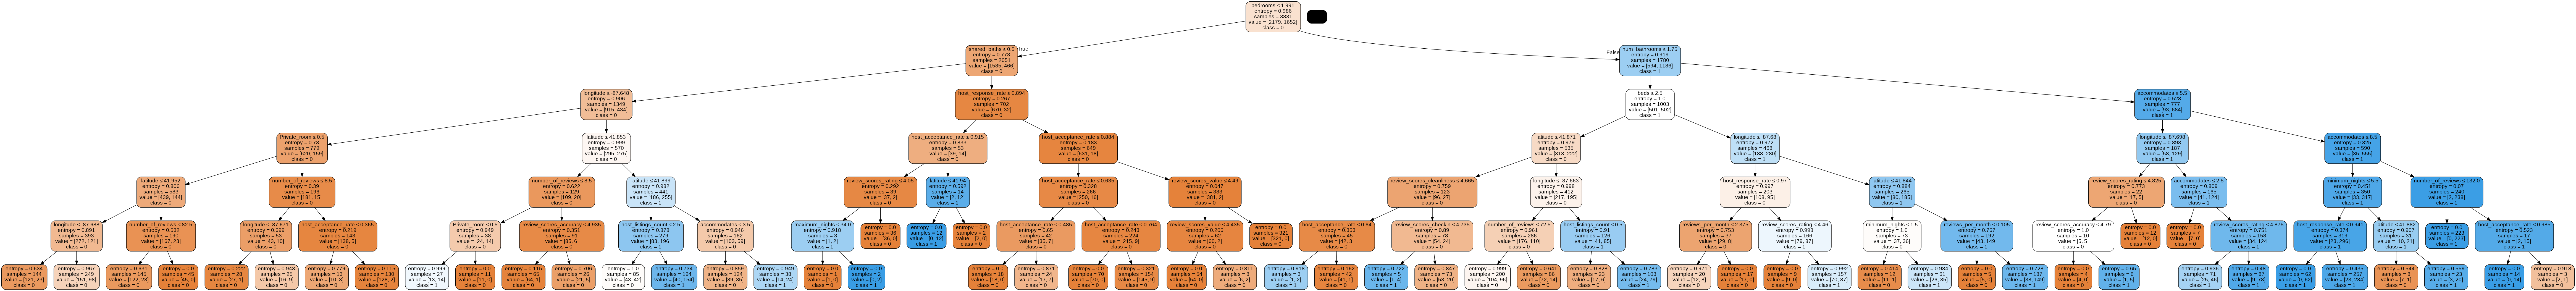

In [ ]:
#visulization
from six import StringIO  
dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = new_features,class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('airbnb.png')
Image(graph.create_png())

# text analysis

In [ ]:
df2[['description']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6528 entries, 0 to 6527
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   description  6512 non-null   object
dtypes: object(1)
memory usage: 422.0+ KB


In [ ]:
df2['description'][0]

'If you are fully vaccinated, and able to climb 30 steps, you are invited to be the sole Airbnb guest in my quiet, vintage, 2nd floor apartment shared only with me. This Hyde Park location is convenient for visiting The University of Chicago or attending a convention/conference at McCormick Place. The listing is a block from the eastern border of UChicago,  a 7 minute walk to Chicago Theological Seminary, and a 16 minutes door-to-door ride to McCormick Place via the Metra Electric train.<br /><br /><b>The space</b><br />The private bedroom has a queen size bed, bedside tables w/lamps, a chest of drawers, a desk and chair, and a smart TV. The large closet contains plenty of hangers, an iron and ironing board, a garment steamer, and extra bedding. There is room in the large closet to store your luggage. <br /><br />All bedding (including mattress pad and duvet cover or quilt) is freshly laundered for each guest. During extended stays, weekly housekeeping is provided to the guest room at 